<a href="https://colab.research.google.com/github/abhi12ravi/BERTopic_Conf42/blob/main/Named_Entity_Recognition_v1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install tensorflow keras seaborn

In [7]:
#import the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from numpy.random import seed
from itertools import chain
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import LSTM,Embedding,Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D,Bidirectional
#plt.style.use('seaborn-v0_8')

In [8]:
data=pd.read_csv('ner_dataset.csv',encoding='unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [9]:
#Delete the POS column as we do not need it
data.drop('POS',axis='columns',inplace=True)

In [10]:
data.head(15)

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,NaN,of,O
2,NaN,demonstrators,O
3,NaN,have,O
4,NaN,marched,O
5,NaN,through,O
6,NaN,London,B-geo
7,NaN,to,O
8,NaN,protest,O
9,NaN,the,O


In [11]:
#NaN values to be filled using Forward Fill method.
data=data.fillna(method='ffill')

<ipython-input-11-45638fe461c8>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data=data.fillna(method='ffill')


In [12]:
data.head(35)

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O
5,Sentence: 1,through,O
6,Sentence: 1,London,B-geo
7,Sentence: 1,to,O
8,Sentence: 1,protest,O
9,Sentence: 1,the,O


In [17]:
'''Extracting unique values from the 'Word' column of the DataFrame data. It is using the set() function
to create a set of unique words and then converting that set back into a list. So, the variable words
will contain a list of unique words found in the 'Word' column of the DataFrame.'''

words=list(set(data['Word'].values))

'''Adding the string "ENDPAD" to the end of the words list. The term "ENDPAD" is often used in natural
language processing tasks, such as sequence labeling, to indicate the end of a sequence. It's a common
practice to have a special token like this in NLP tasks.'''

words.append("ENDPAD")

''' Accessing the last element of the words list, which is now "ENDPAD". By using the index -1, referencing the last element in the list.'''
words[-1]

'ENDPAD'

In [18]:
words[-10:]

['shares',
 'Jr',
 'pulp',
 'full-fledged',
 'waning',
 'mainly',
 'justified',
 'ransom',
 'incorporated',
 'ENDPAD']

In [19]:
#Total no. of words
num_words=len(data['Word'])
print("Total number of words",num_words)

Total number of words 1048575


In [20]:
#List of Tags and total no. of Tags
tags = list(set(data["Tag"].values))
num_tags = len(tags)
num_tags
print("List of tags: " + ', '.join([tag for tag in tags]))
print(f"Total Number of tags {num_tags}")

List of tags: B-per, I-art, B-eve, B-org, I-org, I-geo, B-tim, I-eve, I-nat, B-geo, B-gpe, B-nat, I-tim, B-art, O, I-per, I-gpe
Total Number of tags 17


In [21]:
data.head()

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O


In [22]:
#Creating a class which will give the complete sentence with Tags attached with each word
class Get_sentence(object):
  def __init__(self,data):
    self.n_sent=1
    self.data=data
    agg_func=lambda s:[(w,t) for w,t in zip(s['Word'].tolist(),s['Tag'].tolist())]
    self.grouped=self.data.groupby('Sentence #').apply(agg_func)
    self.sentences=[s for s in self.grouped]

In [23]:
getter=Get_sentence(data)
sentence=getter.sentences

<ipython-input-22-7a59fbbb5a8b>:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped=self.data.groupby('Sentence #').apply(agg_func)


In [24]:
sentence[0]

[('Thousands', 'O'),
 ('of', 'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]

### Data Visualizaion

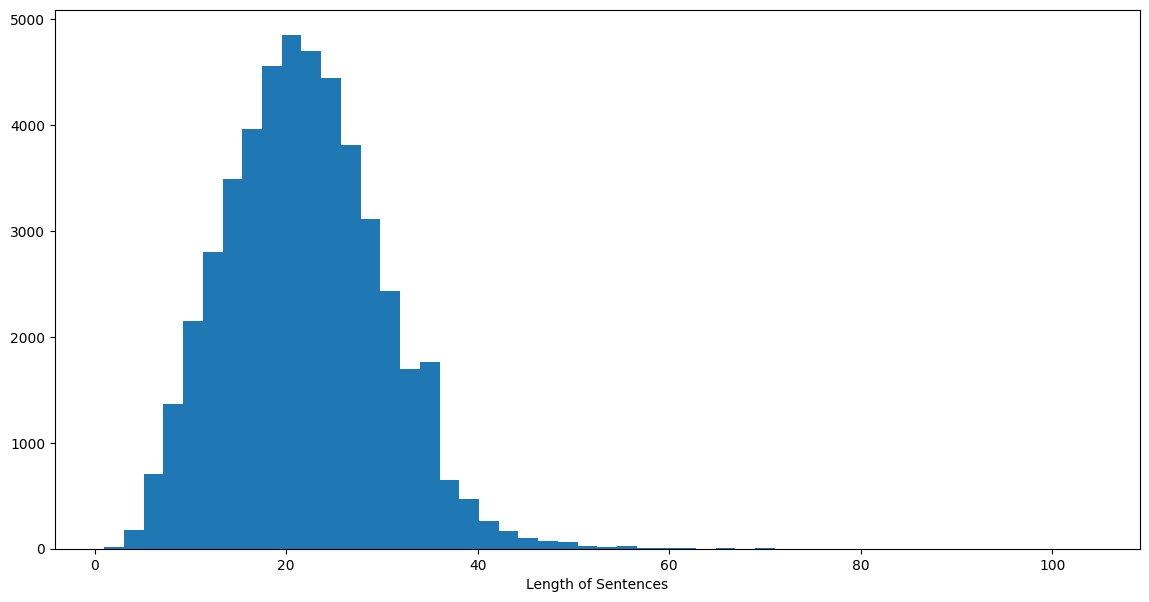

In [26]:
plt.figure(figsize=(14,7))
plt.hist([len(s) for s in sentence],bins = 50)
plt.xlabel("Length of Sentences")
plt.show()

# Most of our sentenses have a length of 20 words, the longest sentense is around 63 words


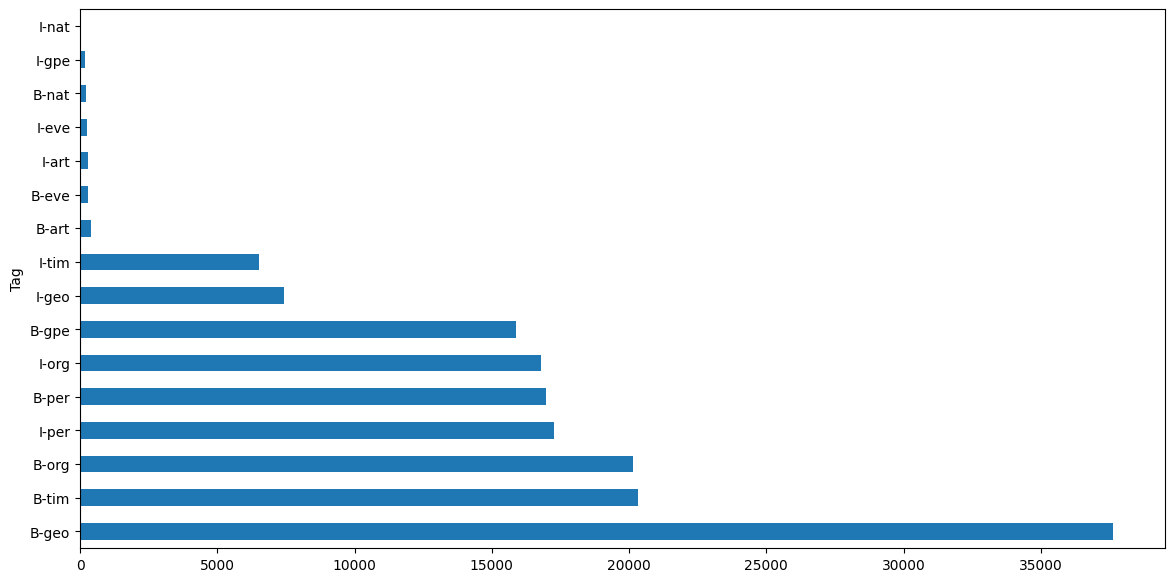

In [27]:
plt.figure(figsize=(14, 7))
data.Tag[data.Tag != 'O']\
    .value_counts()\
    .plot\
    .barh();

In [28]:
## We can understand from the bar chart above that B-geo Tags are over-represented.
## I-nat and I-gpe Tags are negligible and almost non-existent. Model will have difficulty in classifying these 2 tags.

In [29]:
# Data Preparation

In [30]:
word_idx = {w : i + 1 for i ,w in enumerate(words)}
tag_idx =  {t : i for i ,t in enumerate(tags)}

In [31]:
len(tag_idx)

17

In [32]:
word_idx['PAD']=0

In [33]:
word_idx['Dniester']

19256

In [34]:
# Padding our sentences using max lenght of 50.
max_len=50
X=[[word_idx[w[0]] for w in s] for s in sentence]
X=pad_sequences(maxlen=max_len,sequences=X,padding='post',value=num_words-1)
y=[[tag_idx[w[1]]for w in s]for s in sentence]
y=pad_sequences(maxlen=max_len,sequences=y,padding='post',value=tag_idx['O'])


In [35]:
X[0]

array([  16040,   13796,    7676,   26572,   25511,   27617,    9953,
          7904,   17258,   34164,   24882,   28761,   10575,   32491,
         33737,   34164,   13269,   13796,   33140,   16905,   26873,
         28229,   24272,   22489, 1048574, 1048574, 1048574, 1048574,
       1048574, 1048574, 1048574, 1048574, 1048574, 1048574, 1048574,
       1048574, 1048574, 1048574, 1048574, 1048574, 1048574, 1048574,
       1048574, 1048574, 1048574, 1048574, 1048574, 1048574, 1048574,
       1048574], dtype=int32)

In [36]:
y[0]

array([14, 14, 14, 14, 14, 14,  9, 14, 14, 14, 14, 14,  9, 14, 14, 14, 14,
       14, 10, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14],
      dtype=int32)

In [37]:
y=[to_categorical(i,num_classes=num_tags) for i in y]

In [38]:
num_tags

17

In [39]:
y[0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1

In [40]:
# Split the data using Train Test split.
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)

In [ ]:
# Building the model

In [41]:
input_word=Input(shape=(max_len,))
model=Embedding(input_dim=num_words,output_dim=max_len,input_length=max_len)(input_word)
model=SpatialDropout1D(0.1)(model)
model=Bidirectional(LSTM(units=100,return_sequences=True,recurrent_dropout=0.1))(model)
out=TimeDistributed(Dense(num_tags,activation='softmax'))(model)
model=Model(input_word,out)

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 50, 50)              │      52,428,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 50, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 50, 200)             │         120,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 50, 17)              │           3,417 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,552,967 (200.47 MB)

 Trainable params: 52,552,967 (200.47 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
plot_model(model,show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [43]:
#Training the model with Training data
model.fit(X_train,np.array(y_train),batch_size=64,verbose=1,epochs=3,validation_split=0.2)

Epoch 1/3
480/480 ━━━━━━━━━━━━━━━━━━━━ 864s 2s/step - accuracy: 0.9258 - loss: 0.4364 - val_accuracy: 0.9727 - val_loss: 0.1018
Epoch 2/3
480/480 ━━━━━━━━━━━━━━━━━━━━ 855s 2s/step - accuracy: 0.9774 - loss: 0.0820 - val_accuracy: 0.9830 - val_loss: 0.0576
Epoch 3/3
480/480 ━━━━━━━━━━━━━━━━━━━━ 857s 2s/step - accuracy: 0.9863 - loss: 0.0471 - val_accuracy: 0.9848 - val_loss: 0.0501


In [44]:
# Model Evaluation

In [45]:
model.evaluate(X_test,np.array(y_test))

300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9844 - loss: 0.0530


[0.05217946320772171, 0.9845646619796753]

In [46]:
# Model Prediction with Test set
rand_sent=np.random.randint(0,X_test.shape[0])
p=model.predict(np.array([X_test[rand_sent]]))
p=np.argmax(p,axis=-1)

y_true=np.argmax(np.array(y_test),axis=-1)[rand_sent]

print("{:20}{:20}\t{}\n".format("Word","True","Pred"))
print("-"*55)

for (w,t,pred)in zip(X_test[rand_sent],y_true,p[0]):
  print("{:20}{:20}\t{}".format(words[w-1],tags[t],tags[pred]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step
Word                True                	Pred

-------------------------------------------------------
India               B-geo               	B-geo
has                 O                   	O
unveiled            O                   	O
a                   O                   	O
number              O                   	O
of                  O                   	O
new                 O                   	O
measures            O                   	O
to                  O                   	O
spur                O                   	O
people-to-people    O                   	O
contacts            O                   	O
with                O                   	O
Pakistan            B-geo               	B-geo
ahead               O                   	O
of                  O                   	O
a                   O                   	O
trip                O                   	O
to                  O                   	O
Islamabad           B-geo        

IndexError: list index out of range